# Cyber Security and Artificial Intelligence - Task #1

## Ron Kozitsa
## Adi Dereviani Prager

## imports

In [2]:
import pandas as pd
import re
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from gensim import corpora, models
from IPython.display import HTML
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import numpy as np
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import random
import spacy
from spacy.matcher import Matcher
import pickle
# Load the pre-trained English NER model (we chose the large one, to be more precise)
# !python -m spacy download en_core_web_lg
nlp = spacy.load("en_core_web_lg")
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS
import networkx as nx
from collections import Counter
from plotly import graph_objs as go

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

np.random.seed(10)


## Load the original Dataset from Kaggle

In [4]:
file_path_original = './emails.csv'
emails_df_original = pd.read_csv(file_path_original)

Let's see what our dataset looks like:

In [3]:
emails_df_original.head()

file                                            message
0     allen-p/_sent_mail/1.  Message-ID: <18782981.1075855378110.JavaMail.e...
1    allen-p/_sent_mail/10.  Message-ID: <15464986.1075855378456.JavaMail.e...
2   allen-p/_sent_mail/100.  Message-ID: <24216240.1075855687451.JavaMail.e...
3  allen-p/_sent_mail/1000.  Message-ID: <13505866.1075863688222.JavaMail.e...
4  allen-p/_sent_mail/1001.  Message-ID: <30922949.1075863688243.JavaMail.e...

In [4]:
emails_df_original.shape

(517401, 2)

In [5]:
emails_df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517401 entries, 0 to 517400
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   file     517401 non-null  object
 1   message  517401 non-null  object
dtypes: object(2)
memory usage: 7.9+ MB


## Missing Data

Let's see if we have missing data:

In [6]:
emails_df_original.isnull()

file  message
0       False    False
1       False    False
2       False    False
3       False    False
4       False    False
...       ...      ...
517396  False    False
517397  False    False
517398  False    False
517399  False    False
517400  False    False

[517401 rows x 2 columns]

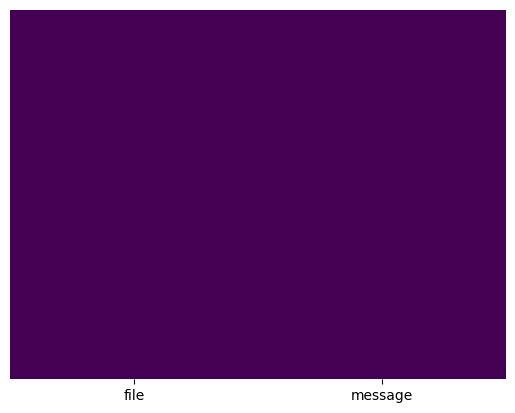

In [7]:
sns.heatmap(emails_df_original.isnull(),yticklabels=False,cbar=False,cmap='viridis');

Make sure no rows are duplicated:

In [8]:
print(f"Number of duplicated rows: {emails_df_original.duplicated().sum()}")

Number of duplicated rows: 0


## Get from Kaggel format to the given format

### Extra step - in case we needed to start from the Kaggel DS

In [9]:
# Define patterns to extract each email component
headers_pattern = {
    'Date': re.compile(r"Date: (.+?)\n"),
    'From': re.compile(r"From: (.+?)\n"),
    'To': re.compile(r"To: (.+?)\n"),
    'X-To': re.compile(r"X-To: (.+?)\n"),
    'X-From': re.compile(r"X-From: (.+?)\n"),
    'X-cc': re.compile(r"X-cc: (.+?)\n"),
    'X-bcc': re.compile(r"X-bcc: (.+?)\n"),
    'Subject': re.compile(r"Subject: (.+?)\n"),
    'email_body': re.compile(r"\n\n(.+)", re.DOTALL),
}

# Initialize a dictionary to hold the parsed data
parsed_data = {
    'Date': [],
    'From': [],
    'To': [],
    'X-To': [],
    'X-From': [],
    'X-cc': [],
    'X-bcc': [],
    'Subject': [],
    'email_body': [],
}

# Function to parse and extract data
def parse_email(message):
    for key, pattern in headers_pattern.items():
        match = pattern.search(message)
        parsed_data[key].append(match.group(1).strip() if match else "")

# Apply parsing to each message
emails_df_original['message'].apply(parse_email)

# Convert the parsed data into a DataFrame
parsed_emails_df = pd.DataFrame(parsed_data)

# Add 'verdict' and 'violated_rules' columns with default empty strings
parsed_emails_df['verdict'] = ""
parsed_emails_df['violated_rules'] = ""


## Load the labeled Dataset

In [9]:
file_path = './enron_students.pkl'
emails_df = pd.read_pickle(file_path)

In [10]:
emails_df.head()

Date                     From  \
0  Mon, 14 May 2001 16:39:00 -0700 (PDT)  phillip.allen@enron.com   
1   Fri, 4 May 2001 13:51:00 -0700 (PDT)  phillip.allen@enron.com   
2  Wed, 18 Oct 2000 03:00:00 -0700 (PDT)  phillip.allen@enron.com   
3  Mon, 23 Oct 2000 06:13:00 -0700 (PDT)  phillip.allen@enron.com   
4  Thu, 31 Aug 2000 05:07:00 -0700 (PDT)  phillip.allen@enron.com   

                        To                                               X-To  \
0     tim.belden@enron.com           Tim Belden <Tim Belden/Enron@EnronXGate>   
1  john.lavorato@enron.com  John J Lavorato <John J Lavorato/ENRON@enronXg...   
2   leah.arsdall@enron.com                                   Leah Van Arsdall   
3    randall.gay@enron.com                                      Randall L Gay   
4     greg.piper@enron.com                                         Greg Piper   

            X-From X-cc X-bcc    Subject  \
0  Phillip K Allen                         
1  Phillip K Allen                   Re:   
2  Phillip K Allen              Re: test   
3  Phillip K Allen                         
4  Phillip K Allen             Re: Hello   

                                          email_body verdict violated_rules  
0                          Here is our forecast\n\n    ALLOW                 
1  Traveling to have a business meeting takes the...   ALLOW                 
2                     test successful.  way to go!!!   ALLOW                 
3  Randy,\n\n Can you send me a schedule of the s...   ALLOW                 
4                Let's shoot for Tuesday at 11:45.     ALLOW

In [12]:
emails_df.shape

(517401, 11)

# Exploratory data analysis (EDA)

Make sure no rows are duplicated:

In [13]:
dup_rows = emails_df.duplicated().sum()
print(f"Number of duplicated rows: {dup_rows}")

Number of duplicated rows: 260393


As we can see, compared to the original dataset from Kaggle, duplicate rows were found in the tagged dataset we received.

We will now examine the duplicate rows in our tagged data to ensure they are indeed duplicates.

In [11]:
def analyze_and_remove_duplicates(df, suspect_columns=None, compare_rows=None):
    # Finding and displaying the number of duplicated rows
    dup_rows = df.duplicated().sum()
    print(f"Number of duplicated rows: {dup_rows}")

    if dup_rows == 0:
        print("No duplicate rows found.")
    else:
        # Marking all duplicates (not just the first occurrence)
        all_duplicates = df[df.duplicated(keep=False)]

        # Sorting by the columns we suspect are causing the duplications to group them together
        if suspect_columns:
            sorted_duplicates = all_duplicates.sort_values(by=suspect_columns)
        else:
            sorted_duplicates = all_duplicates

        # Displaying the sorted duplicates
        print(sorted_duplicates)

        # Grouping by all columns and examining groups that have more than one element
        grouped = df.groupby(df.columns.tolist(), as_index=False).filter(lambda x: len(x) > 1)
        if not grouped.empty:
            print("Duplicate Groups:")
            print(grouped, "\n")

        # Specific example comparison if compare_rows is given
        if compare_rows:
            comparison_result = df.iloc[compare_rows[0]] == df.iloc[compare_rows[1]]
            print("Comparison result (True = identical, False = different):")
            print(comparison_result)
            print("All columns equal:", comparison_result.all())
            print("Email bodies comparison:")
            print(df['email_body'][compare_rows[0]])
            print(df['email_body'][compare_rows[1]])

        # Removing duplicates
        df.drop_duplicates(inplace=True)
        print(f"After removal, we have {df.duplicated().sum()} duplicate rows")

In [54]:
analyze_and_remove_duplicates(emails_df, suspect_columns=['Date', 'From', 'To', 'Subject', 'email_body'], compare_rows=[3492, 4620])

Number of duplicated rows: 260393
                                        Date  \
231076  Fri, 1 Aug 1997 01:00:00 -0700 (PDT)   
233344  Fri, 1 Aug 1997 01:00:00 -0700 (PDT)   
240748  Fri, 1 Aug 1997 01:00:00 -0700 (PDT)   
247580  Fri, 1 Aug 1997 01:00:00 -0700 (PDT)   
12539   Fri, 1 Dec 2000 00:00:00 -0800 (PST)   
...                                      ...   
144931  Wed, 9 May 2001 23:55:00 -0700 (PDT)   
140787  Wed, 9 May 2001 23:57:00 -0700 (PDT)   
142363  Wed, 9 May 2001 23:57:00 -0700 (PDT)   
142712  Wed, 9 May 2001 23:57:00 -0700 (PDT)   
253832  Wed, 9 May 2001 23:57:00 -0700 (PDT)   

                                     From                      To  \
231076              steven.kean@enron.com                    None   
233344              steven.kean@enron.com                    None   
240748              steven.kean@enron.com                    None   
247580              steven.kean@enron.com                    None   
12539            david.baumbach@enron.com   

In [25]:
print(f"After removal, we have {emails_df.duplicated().sum()} duplicate rows")

After removal, we have 0 duplicate rows


After ensuring and confirming that the lines were indeed duplicated, we removed them

In [26]:
emails_df.shape

(257008, 11)

_____________________

Let's see if we have missing data:

In [18]:
emails_df.isnull()

Date   From     To   X-To  X-From   X-cc  X-bcc  Subject  email_body  \
0       False  False  False  False   False  False  False    False       False   
1       False  False  False  False   False  False  False    False       False   
2       False  False  False  False   False  False  False    False       False   
3       False  False  False  False   False  False  False    False       False   
4       False  False  False  False   False  False  False    False       False   
...       ...    ...    ...    ...     ...    ...    ...      ...         ...   
517396  False  False  False  False   False  False  False    False       False   
517397  False  False  False  False   False  False  False    False       False   
517398  False  False  False  False   False  False  False    False       False   
517399  False  False  False  False   False  False  False    False       False   
517400  False  False  False  False   False  False  False    False       False   

        verdict  violated_rules  
0         False           False  
1         False           False  
2         False           False  
3         False           False  
4         False           False  
...         ...             ...  
517396    False           False  
517397    False           False  
517398    False           False  
517399    False           False  
517400    False           False  

[257008 rows x 11 columns]

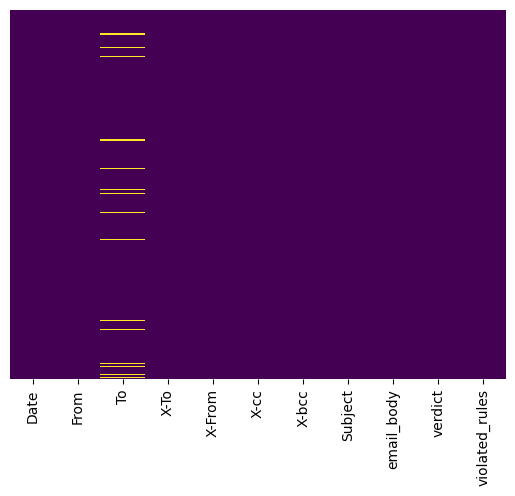

In [19]:
sns.heatmap(emails_df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.show()

As we can see, in the 'TO' column, we supposedly have null data. However, because it's only in the 'TO' field, we assume it's not truly null data. Most likely, the email body contains data and content, so we won't filter this column

Let's test if it's true:

In [20]:
empty_to = emails_df[emails_df['To'].isnull() | (emails_df['To'] == '')]

empty_to_values = empty_to['To']

# Printing the empty 'To' column values
print(empty_to_values)

188       None
603       None
873       None
885       None
1230      None
          ... 
516732    None
516834    None
516846    None
516878    None
516976    None
Name: To, Length: 10448, dtype: object


In [21]:
# Counting the number of rows where 'To' column is empty
num_empty_to = len(empty_to)

# Printing the count
print("Number of rows where 'To' column is empty:", num_empty_to)

Number of rows where 'To' column is empty: 10448


In [22]:
row_with_null_to = emails_df[emails_df['To'].isnull()].head(1)

# Printing the row with null 'To' column
row_with_null_to

Date                     From    To  \
188  Mon, 1 May 2000 03:56:00 -0700 (PDT)  phillip.allen@enron.com  None   

                           X-To           X-From X-cc X-bcc  \
188  Circuit Provisioning@ENRON  Phillip K Allen              

               Subject                                         email_body  \
188  Re: DSL- Installs  No one will be home on 5/11/00 to meet DSL ins...   

    verdict violated_rules  
188   ALLOW

Indeed, after the test, we observed that although there are 'TO' lines that are null, their 'email_body' does contain content. That's why we won't filter them. We'll take that into account from now on

____________________

Network analysis to visualize the communication between different individuals within the organization

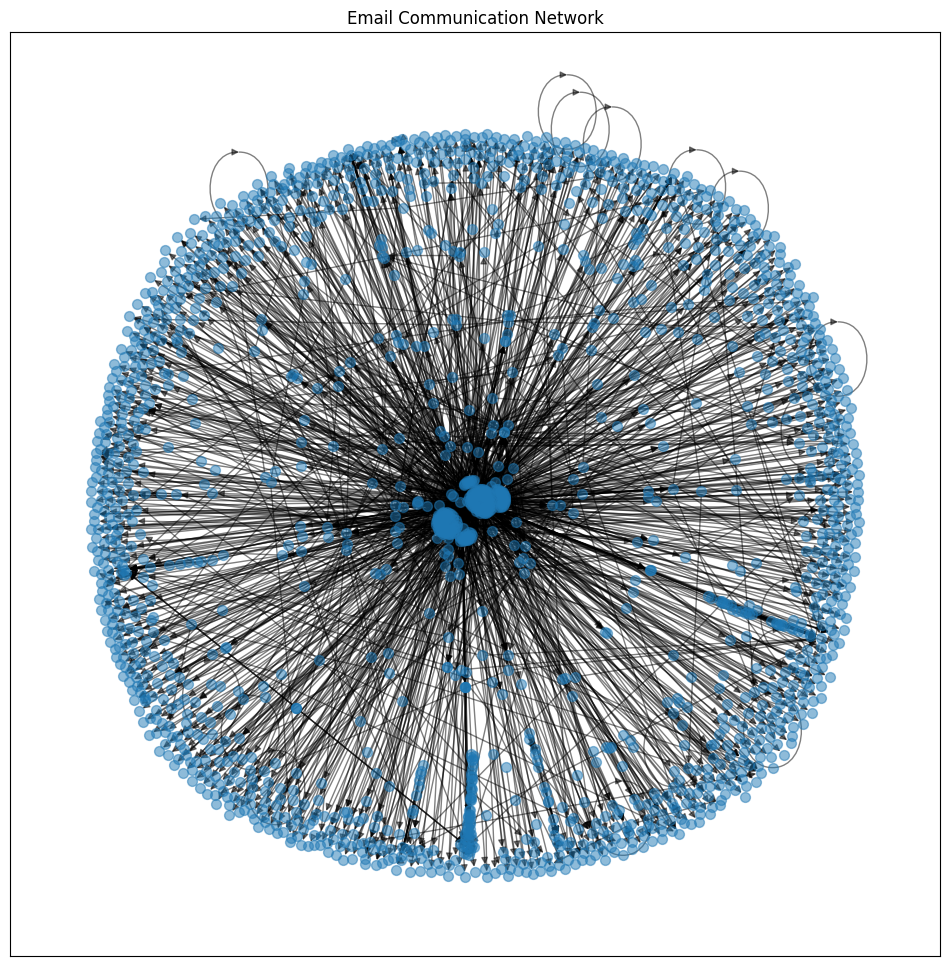

In [6]:
# Temporarily filter out None values just for network creation
temp_df = emails_df.dropna(subset=['From', 'To'])

# Create the graph from the temporary DataFrame
G = nx.from_pandas_edgelist(temp_df, 'From', 'To', create_using=nx.DiGraph())

# Draw the graph
plt.figure(figsize=(12,12))
nx.draw_networkx(G, with_labels=False, node_size=50, font_size=8, alpha=0.5)
plt.title('Email Communication Network')
plt.show()

When we generate a network graph from email data using a library like NetworkX, each node represents an email address, and each directed edge (arrow) represents an email sent from one address to another. The visualization aims to show the flow of communication between different parties within the dataset

___________________

Histograms and barplots for the distribution of email lengths and the distribution of verdicts

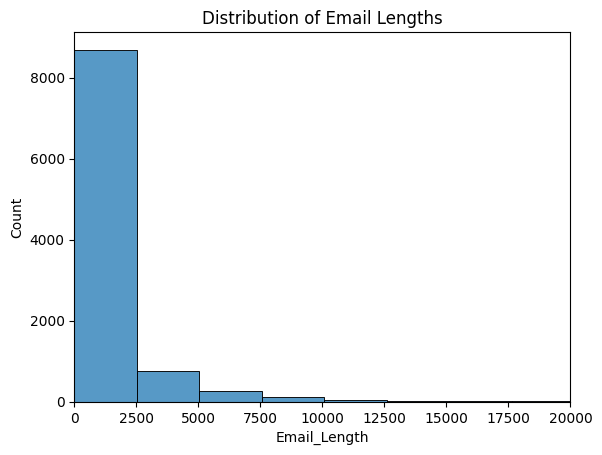

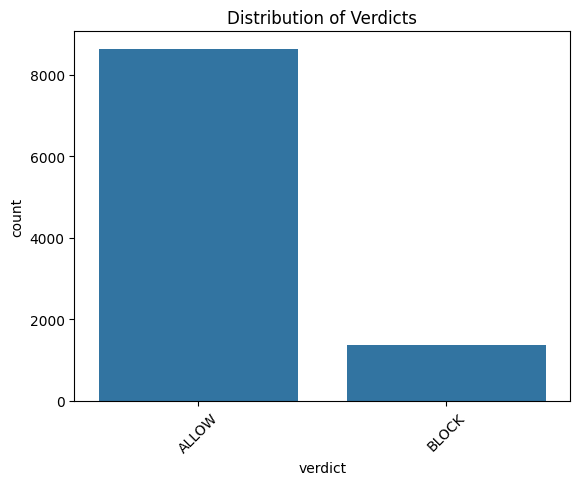

In [7]:
# Histogram of email lengths
emails_df['Email_Length'] = emails_df['email_body'].apply(len)
sns.histplot(emails_df['Email_Length'], bins=50)
plt.title('Distribution of Email Lengths')
plt.xlim(0, 20000)
plt.show()

# Bar plot for verdict categories
sns.countplot(x='verdict', data=emails_df)
plt.title('Distribution of Verdicts')
plt.xticks(rotation=45)
plt.show()

_________________________

## Using Sentiment Analysis

In [15]:
analyser = SentimentIntensityAnalyzer()

# using polarity for sentiment analysis
def sentiment_analyzer_score(sentence):
    score = analyser.polarity_scores(sentence)
    print(f"{sentence: <40} {score}")

def process_email_text(df):
    """
    Tokenizes text in the 'email_body' column, computes descriptive statistics,
    and prints the 50 most common words.
    """
    tokenizer = RegexpTokenizer(r'\w+')
    words_descriptions = df['email_body'].apply(tokenizer.tokenize)

    all_words = []
    description_lengths = []
    for tokens in words_descriptions:
        description_lengths.append(len(tokens))
        all_words.extend(tokens)

    df['description_lengths'] = description_lengths
    vocab = sorted(set(all_words))
    print(f"{len(all_words)} words total, with a vocabulary size of {len(vocab)}")

    # Count and print the 50 most common words
    count_all_words = Counter(all_words)
    most_common_words = count_all_words.most_common(50)
    print("The 50 most common words are:")
    for word, freq in most_common_words:
        print(f"{word}: {freq}")

    return vocab

def generate_wordcloud(df, title='Word Cloud', sentiment=None, background_color='white', frame_color='white', additional_stopwords=None):
    """
    Generates a word cloud from text in the 'email_body' column, optionally filtered by sentiment,
    and adds specified additional stopwords. The plot can have a colored frame based on the sentiment.
    """
    stopwords_set = set(STOPWORDS)
    if additional_stopwords:
        stopwords_set.update(additional_stopwords)

    if sentiment:
        # Filter DataFrame by sentiment if specified
        df = df[df['Sentiment'] == sentiment]
        if df.empty:
            print(f"No data found for '{sentiment}' sentiment.")
            return

    if 'email_body' in df.columns and not df.empty:
        text = ' '.join(df['email_body'])
        wordcloud = WordCloud(
            collocations=False,
            width=800,
            height=800,
            background_color=background_color,
            stopwords=stopwords_set,
            min_font_size=10,
            max_words=150,
            random_state=42
        ).generate(text)

        plt.figure(figsize=(8, 8), facecolor=frame_color)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(title)
        plt.tight_layout(pad=0)
        plt.show()
    else:
        print("Error: 'email_body' column not found or DataFrame is empty.")

def apply_sentiment_analysis(df):
    """
    Applies sentiment analysis to the 'email_body' column, assigning a sentiment
    category based on the compound score.
    """
    analyser = SentimentIntensityAnalyzer()
    df['scores'] = df['email_body'].apply(analyser.polarity_scores)
    df['compound'] = df['scores'].apply(lambda score_dict: score_dict['compound'])
    df['Sentiment'] = df['compound'].apply(lambda x: 'Positive' if x >= 0.05 else 'Negative' if x <= -0.05 else 'Neutral')
    return df

def plot_sentiment_distribution(df):
    """
    Plots a bar chart of sentiment distribution based on the 'Sentiment' column.
    """
    plt.figure(figsize=(8, 6))
    df.groupby('Sentiment').email_body.count().plot.bar(ylim=0)
    plt.show()

In [28]:
vocab = process_email_text(emails_df)

76059110 words total, with a vocabulary size of 738684
The 50 most common words are:
the: 2408954
to: 1704819
and: 1232701
of: 1128323
a: 929106
in: 766969
com: 713846
for: 665173
is: 585571
you: 567054
on: 565012
I: 540252
that: 506355
s: 454775
20: 453085
Enron: 445229
ECT: 412598
be: 401115
this: 357525
with: 357215
have: 328697
will: 325219
or: 317681
are: 316039
at: 311901
The: 299784
by: 298182
2001: 287675
it: 267640
To: 263905
as: 262744
from: 256905
1: 248027
not: 243601
we: 242529
http: 236851
your: 225750
Subject: 220772
09: 215528
HOU: 211751
2: 183894
an: 175546
PM: 175496
has: 162101
00: 161385
10: 158557
From: 156666
01: 155548
was: 155229
would: 153254


In [4]:
apply_sentiment_analysis(emails_df)
emails_df.head()

Date                     From  \
0  Mon, 14 May 2001 16:39:00 -0700 (PDT)  phillip.allen@enron.com   
1   Fri, 4 May 2001 13:51:00 -0700 (PDT)  phillip.allen@enron.com   
2  Wed, 18 Oct 2000 03:00:00 -0700 (PDT)  phillip.allen@enron.com   
3  Mon, 23 Oct 2000 06:13:00 -0700 (PDT)  phillip.allen@enron.com   
4  Thu, 31 Aug 2000 05:07:00 -0700 (PDT)  phillip.allen@enron.com   

                        To                                               X-To  \
0     tim.belden@enron.com           Tim Belden <Tim Belden/Enron@EnronXGate>   
1  john.lavorato@enron.com  John J Lavorato <John J Lavorato/ENRON@enronXg...   
2   leah.arsdall@enron.com                                   Leah Van Arsdall   
3    randall.gay@enron.com                                      Randall L Gay   
4     greg.piper@enron.com                                         Greg Piper   

            X-From X-cc X-bcc    Subject  \
0  Phillip K Allen                         
1  Phillip K Allen                   Re:   
2  Phillip K Allen              Re: test   
3  Phillip K Allen                         
4  Phillip K Allen             Re: Hello   

                                          email_body verdict violated_rules  \
0                          Here is our forecast\n\n    ALLOW                  
1  Traveling to have a business meeting takes the...   ALLOW                  
2                     test successful.  way to go!!!   ALLOW                  
3  Randy,\n\n Can you send me a schedule of the s...   ALLOW                  
4                Let's shoot for Tuesday at 11:45.     ALLOW                  

                                              scores  compound Sentiment  
0  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...    0.0000   Neutral  
1  {'neg': 0.0, 'neu': 0.893, 'pos': 0.107, 'comp...    0.9313  Positive  
2  {'neg': 0.0, 'neu': 0.461, 'pos': 0.539, 'comp...    0.6884  Positive  
3  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...    0.0000   Neutral  
4  {'neg': 0.324, 'neu': 0.676, 'pos': 0.0, 'comp...   -0.3400  Negative

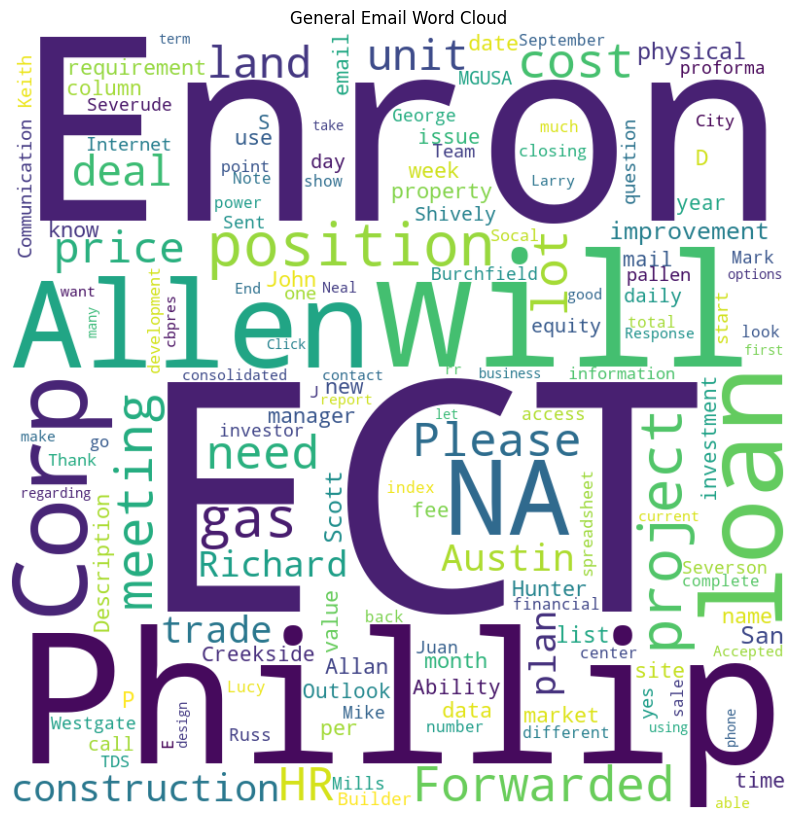

In [49]:
generate_wordcloud(emails_df, title='General Email Word Cloud', additional_stopwords=['FW', 'ga', 'httpitcappscorpenroncomsrrsauthemaillinkaspidpage', 'cc', 'aa', 'aaa', 'aaaa', 'hou', 'etc', 'subject', 'pm'])

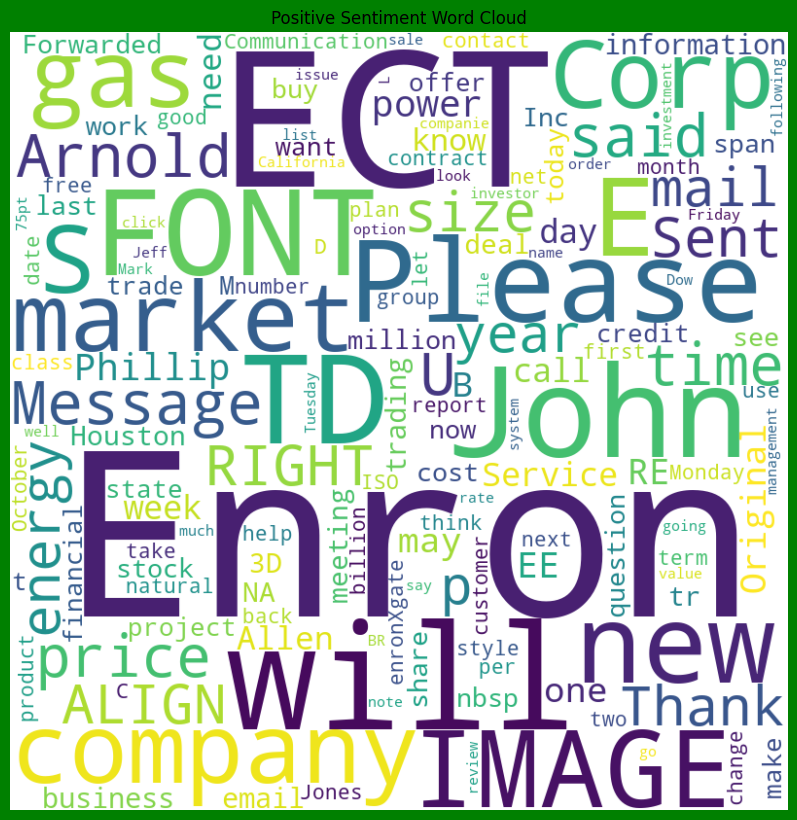

In [5]:
# Positive Sentiment Word Cloud with green frame
generate_wordcloud(emails_df, title='Positive Sentiment Word Cloud', sentiment='Positive', background_color='white', frame_color='green', additional_stopwords=['FW', 'ga', 'httpitcappscorpenroncomsrrsauthemaillinkaspidpage', 'cc', 'aa', 'aaa', 'aaaa', 'hou', 'etc', 'subject', 'pm'])

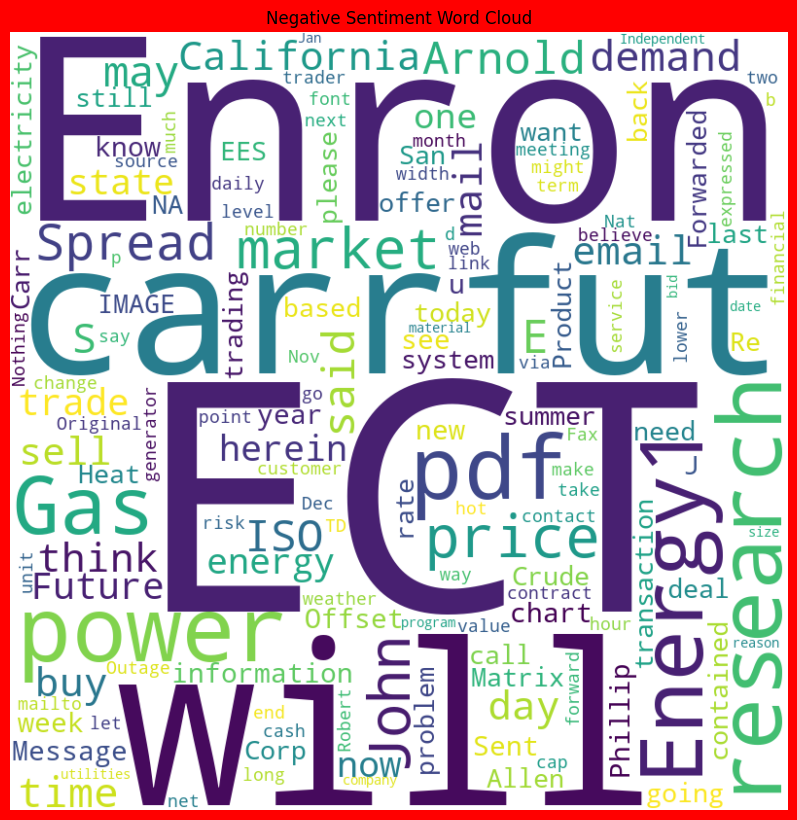

In [6]:
# Negative Sentiment Word Cloud with red frame
generate_wordcloud(emails_df, title='Negative Sentiment Word Cloud', sentiment='Negative', background_color='white', frame_color='red', additional_stopwords=['FW', 'ga', 'httpitcappscorpenroncomsrrsauthemaillinkaspidpage', 'cc', 'aa', 'aaa', 'aaaa', 'hou', 'etc', 'subject', 'pm'])

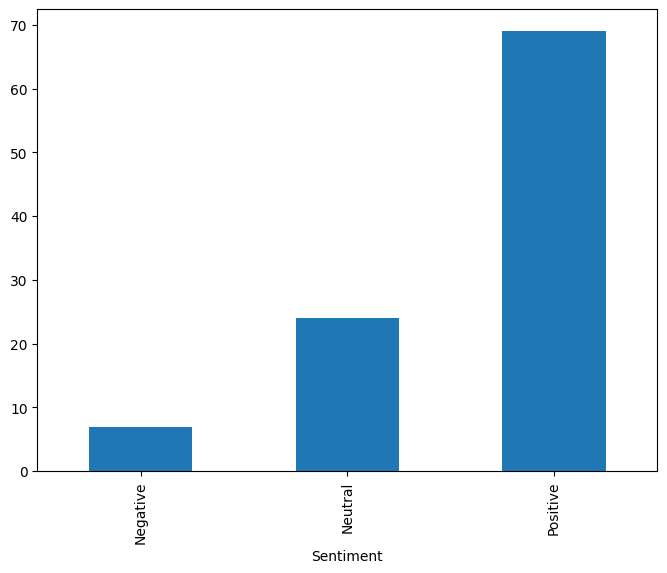

In [52]:
plot_sentiment_distribution(emails_df)

In [53]:
sentiment_emails_df = emails_df[['email_body','Sentiment']].copy()
sentiment_emails_df.head()

email_body Sentiment
0                          Here is our forecast\n\n    Neutral
1  Traveling to have a business meeting takes the...  Positive
2                     test successful.  way to go!!!  Positive
3  Randy,\n\n Can you send me a schedule of the s...   Neutral
4                Let's shoot for Tuesday at 11:45.    Negative

## Data Preparation and Formatting

This part of the code is dedicated to loading and preprocessing email data. It involves cleaning the text using regular expressions to remove unnecessary metadata and formatting, and then standardizing the text through tokenization and lemmatization. The output is a DataFrame with processed text ready for analysis

In [19]:
# nltk.download('wordnet')
# nltk.download('stopwords')
# Tokenization and preprocessing
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    tokens = tokenizer.tokenize(text.lower())
    non_stop_tokens = [token for token in tokens if token not in stop_words and len(token) > 2 and not token.isdigit()]
    lemmatized = [lemmatizer.lemmatize(token) for token in non_stop_tokens]
    return lemmatized

emails_df['processed_text'] = emails_df['email_body'].apply(preprocess_text)

In [24]:
emails_df.head()

Date                     From  \
0  Mon, 14 May 2001 16:39:00 -0700 (PDT)  phillip.allen@enron.com   
1   Fri, 4 May 2001 13:51:00 -0700 (PDT)  phillip.allen@enron.com   
2  Wed, 18 Oct 2000 03:00:00 -0700 (PDT)  phillip.allen@enron.com   
3  Mon, 23 Oct 2000 06:13:00 -0700 (PDT)  phillip.allen@enron.com   
4  Thu, 31 Aug 2000 05:07:00 -0700 (PDT)  phillip.allen@enron.com   

                        To                                               X-To  \
0     tim.belden@enron.com           Tim Belden <Tim Belden/Enron@EnronXGate>   
1  john.lavorato@enron.com  John J Lavorato <John J Lavorato/ENRON@enronXg...   
2   leah.arsdall@enron.com                                   Leah Van Arsdall   
3    randall.gay@enron.com                                      Randall L Gay   
4     greg.piper@enron.com                                         Greg Piper   

            X-From X-cc X-bcc    Subject  \
0  Phillip K Allen                         
1  Phillip K Allen                   Re:   
2  Phillip K Allen              Re: test   
3  Phillip K Allen                         
4  Phillip K Allen             Re: Hello   

                                          email_body verdict violated_rules  \
0                          Here is our forecast\n\n    ALLOW                  
1  Traveling to have a business meeting takes the...   ALLOW                  
2                     test successful.  way to go!!!   ALLOW                  
3  Randy,\n\n Can you send me a schedule of the s...   ALLOW                  
4                Let's shoot for Tuesday at 11:45.     ALLOW                  

                                      processed_text  
0                                         [forecast]  
1  [traveling, business, meeting, take, fun, trip...  
2                            [test, successful, way]  
3  [randy, send, schedule, salary, level, everyon...  
4                              [let, shoot, tuesday]

## Topic Modeling - LDA

This section applies Latent Dirichlet Allocation (LDA) to the preprocessed text to discover underlying topics. It constructs a dictionary and corpus from the text, fits an LDA model to identify topics, and then formats the output to highlight these topics within the texts. This helps in visualizing and understanding the major themes across the documents

In [33]:
# Function to generate a color palette
def generate_color_palette(num_topics):
    return sns.color_palette("hsv", num_topics)

def analyze_topics(dataframe, num_topics_list):
    # Preprocessing and setting up LDA models
    def generate_lda_models(texts, num_topics_list):
        dictionary = corpora.Dictionary(texts)
        corpus = [dictionary.doc2bow(text) for text in texts]
        lda_models = {}
        for num_topics in num_topics_list:
            lda = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)
            lda_models[num_topics] = lda
        return lda_models, dictionary, corpus

    lda_models, dictionary, corpus = generate_lda_models(dataframe['processed_text'], num_topics_list)

    # t-SNE and silhouette analysis
    def tsne_and_silhouette(lda_models, corpus, dictionary):
        silhouette_scores = {}
        for num_topics, lda in lda_models.items():
            doc_topics = [lda.get_document_topics(bow, minimum_probability=0) for bow in corpus]
            topic_matrix = np.zeros((len(doc_topics), num_topics))
            for i, doc in enumerate(doc_topics):
                for topic, prob in doc:
                    topic_matrix[i, topic] = prob
            topic_matrix = normalize(topic_matrix, norm='l1')
            tsne_model = TSNE(n_components=2, perplexity=min(30, len(corpus)//3), learning_rate=200, n_iter=3000, random_state=0)
            tsne_values = tsne_model.fit_transform(topic_matrix)
            labels = np.argmax(topic_matrix, axis=1)
            if len(set(labels)) > 1:
                score = silhouette_score(tsne_values, labels)
                silhouette_scores[num_topics] = score
                plt.figure(figsize=(12, 8))
                unique_labels = len(set(labels))
                if unique_labels > 1:
                    palette = sns.color_palette("hsv", unique_labels)
                    sns.scatterplot(x=tsne_values[:, 0], y=tsne_values[:, 1], hue=labels, legend='full', palette=palette)
                    plt.title(f'Silhouette Score: {score:.2f} for {num_topics} Topics')
                    plt.show()
                else:
                    print(f"Not enough topic variation for {num_topics} topics.")
        return silhouette_scores

    silhouette_scores = tsne_and_silhouette(lda_models, corpus, dictionary)

    # Selecting the optimal number of topics
    optimal_topics = max(silhouette_scores, key=silhouette_scores.get)
    print("Silhouette scores:", silhouette_scores)
    print(f"The optimal number of topics based on Silhouette Score is: {optimal_topics}")

    # Train a final LDA model with the optimal number of topics
    ldamodel = models.ldamodel.LdaModel(corpus, num_topics=optimal_topics, id2word=dictionary, passes=50)
    return ldamodel, dictionary, optimal_topics, silhouette_scores

# Format a document for visualization
def format_document(doc_index, ldamodel, dictionary, num_topics):
    if doc_index >= len(emails_df) or doc_index < 0:
        raise ValueError("Document index is out of bounds.")

    raw_text = emails_df['email_body'].iloc[doc_index]
    processed_doc = emails_df['processed_text'].iloc[doc_index]
    doc_bow = dictionary.doc2bow(processed_doc)

    doc_topics = ldamodel.get_document_topics(doc_bow, minimum_probability=0.1)
    doc_topics = sorted(doc_topics, key=lambda x: x[1], reverse=True)[:3]  # Take the top 3 contributions

    colors = generate_color_palette(num_topics)
    topic_id_to_color = {topic_id: f"rgba({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)}, {{}})" for topic_id, color in zip(range(num_topics), colors)}

    topic_words = {}
    for topic_id, words in ldamodel.show_topics(num_topics=-1, num_words=10, formatted=False):
        topic_words[topic_id] = [word for word, _ in words]

    topic_descriptions = []
    for topic_id, prob in doc_topics:
        if topic_id in topic_id_to_color:
            color = topic_id_to_color[topic_id].format(1)
            words_colored = ' '.join([f"<span style='background-color: {color};'>{word}</span>" for word in topic_words[topic_id]])
            topic_descriptions.append(f"<span style='color: {color};'>Topic {topic_id}:</span> {prob:.1%} {words_colored}")

    html_topics = "<br>".join(topic_descriptions)

    highlighted_text = raw_text
    for word, _ in sum([dictionary.doc2bow(processed_doc)], []):
        for topic_id, prob in doc_topics:
            if dictionary[word] in topic_words[topic_id]:
                if topic_id in topic_id_to_color:
                    color = topic_id_to_color[topic_id].format(prob)
                    styled_word = f"<span style='background-color: {color};'>{dictionary[word]}</span>"
                    highlighted_text = re.sub(r'\b{}\b'.format(re.escape(dictionary[word])), styled_word, highlighted_text, flags=re.IGNORECASE)
                    break

    html_message = highlighted_text.replace('\n', '<br>')
    return f"<div>{html_topics}<br><hr><p>{html_message}</p></div>"

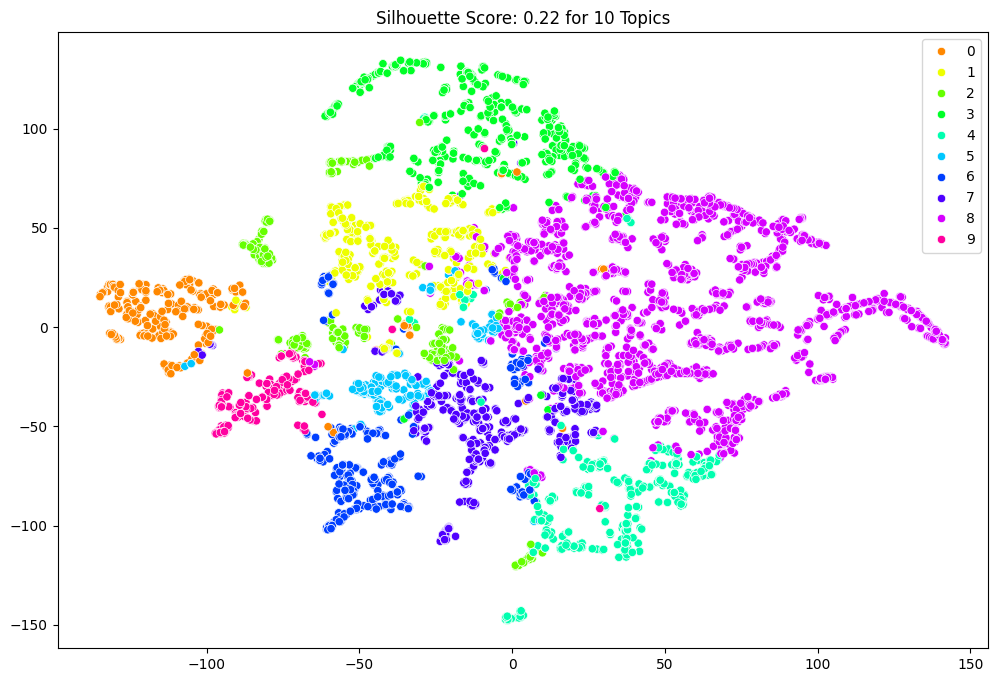

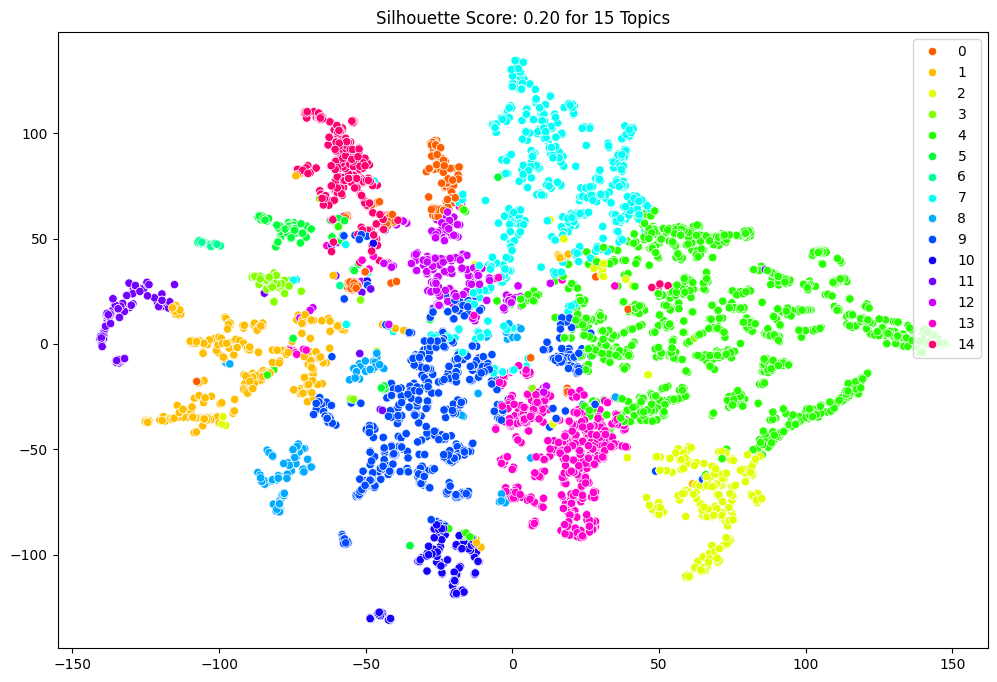

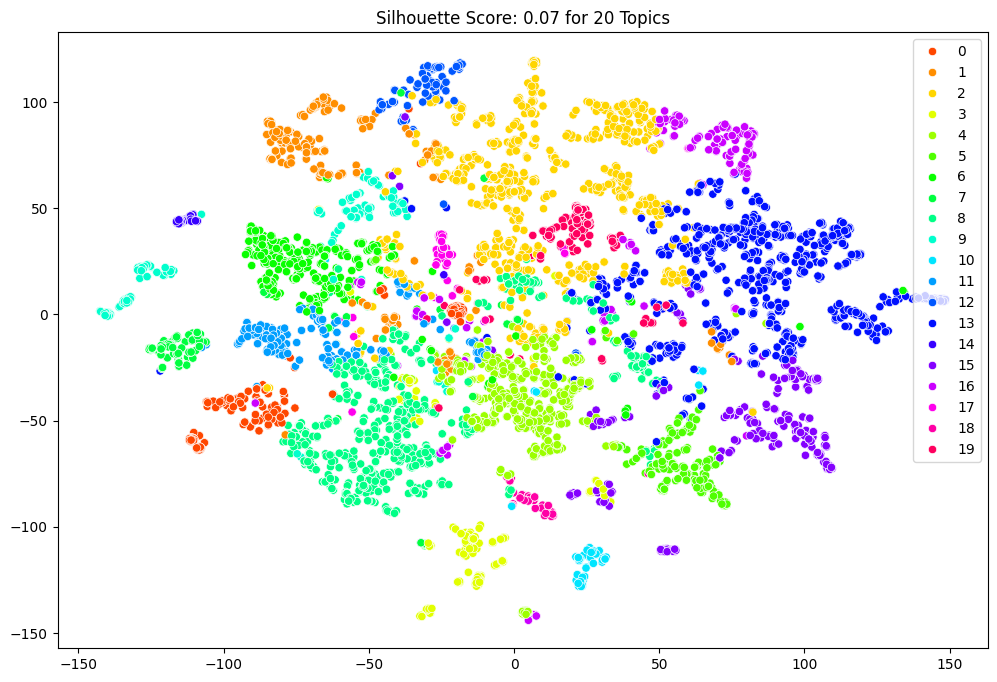

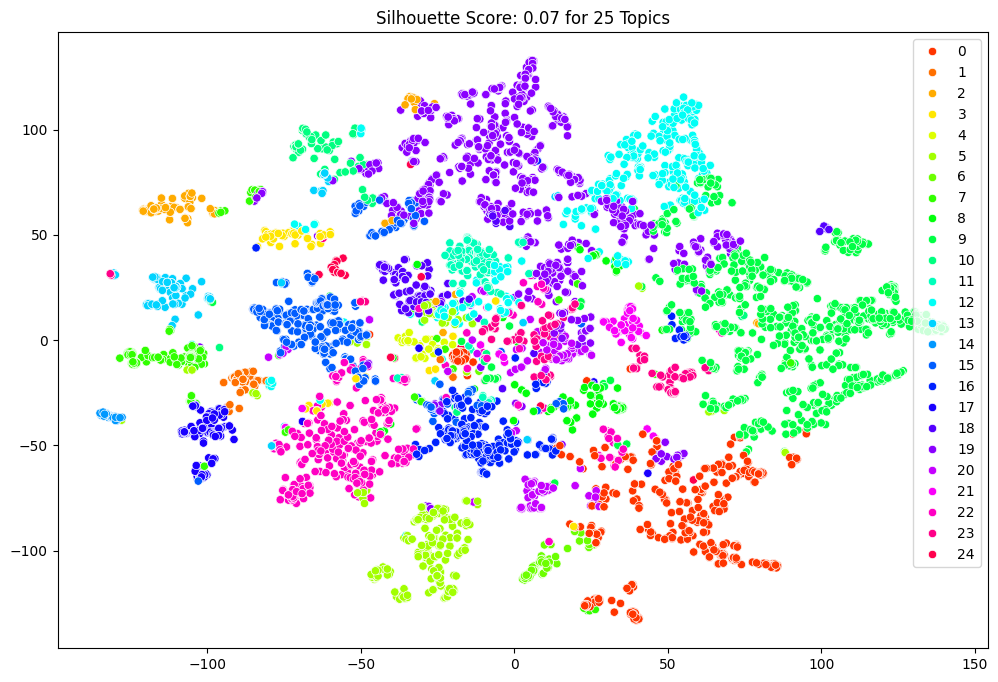

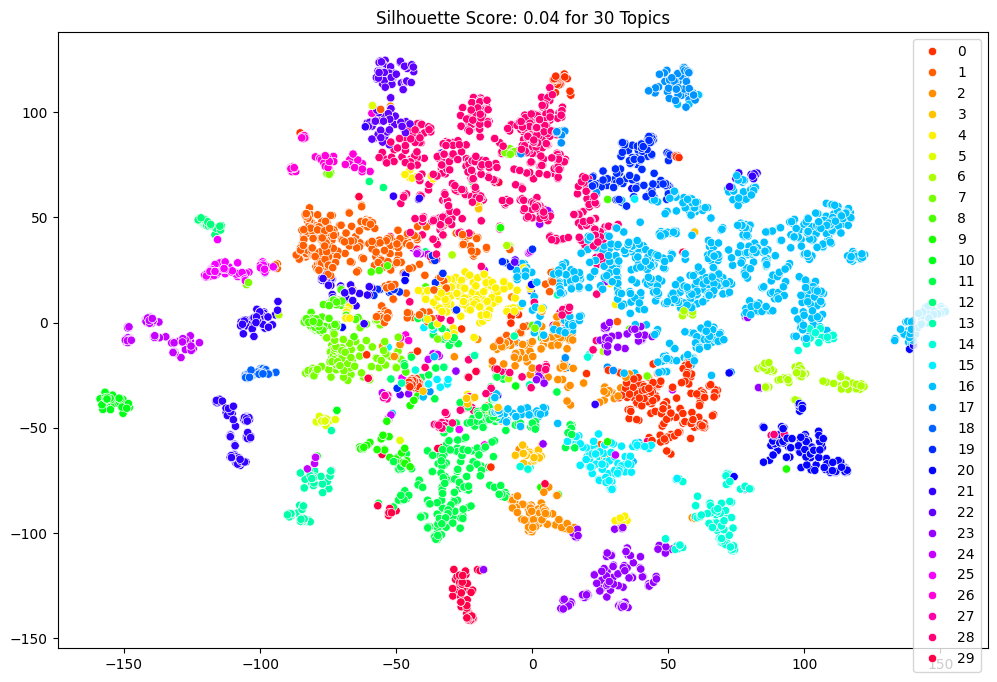

Silhouette scores: {10: 0.2177092, 15: 0.20037879, 20: 0.0677053, 25: 0.06559404, 30: 0.041327}
The optimal number of topics based on Silhouette Score is: 10


In [11]:
ldamodel, dictionary, optimal_topics, silhouette_scores = analyze_topics(emails_df, [10, 15, 20, 25, 30])

In [12]:
num_topics = optimal_topics
example_email_index = random.randint(0, len(emails_df) - 1)
formatted_email = format_document(example_email_index, ldamodel, dictionary, num_topics)

In [13]:
HTML(formatted_email)

List the most common words for that topic from the LDA model:

In [14]:
topic_words_dict = {}

# Extract the words for each topic
for i in range(optimal_topics):
    words = ldamodel.show_topic(i, topn=10)
    topic_words_dict[i] = [word for word, prob in words]

for topic_number, words in topic_words_dict.items():
    print(f"Topic {topic_number}: {', '.join(words)}")

Topic 0: image, com, http, www, click, free, new, please, time, mail
Topic 1: enron, company, said, power, energy, market, price, gas, year, new
Topic 2: ect, hou, john, enron, subject, arnold, allen, phillip, forwarded, corp
Topic 3: iso, cost, would, market, caiso, com, california, phillip, loan, information
Topic 4: message, subject, com, sent, original, enron, john, please, get, know
Topic 5: com, www, http, carrfut, pdf, research, john, energy1, arnold, company
Topic 6: font, size, align, right, nbsp, 75pt, com, span, http, style
Topic 7: enron, ect, hou, corp, ee, communication, enronxgate, jeff, enron_development, please
Topic 8: com, mail, ee, buy, active, pgn, energy, multexinvestor, net, aol
Topic 9: enron, meeting, service, business, would, please, call, information, management, market


It seems that we have found topics referring to business and finance, but not to legal matters.

Therefore, we will explore another method to identify words related to legal issues, one that does not rely on LDA.

_______________________

Now, we will map the topics to 'finance' or 'other' and pront them:

In [34]:
def analyze_finance_topics(emails_df, nlp, ldamodel, dictionary, optimal_topics, finance_keywords):
    # Function to check if a topic is finance-related
    def is_finance_topic(words):
        score = 0
        for word, prob in words:
            if word in finance_keywords:
                score += 1
        return score >= 2

    # Initialize finance topics based on analysis
    finance_topics = set()
    topic_words_dict = {}
    for i in range(optimal_topics):
        topic_words = ldamodel.show_topic(i, topn=10)
        is_finance = is_finance_topic([(word, prob) for word, prob in topic_words])
        if is_finance:
            finance_topics.add(i)
        topic_words_dict[i] = {
            'words': [word for word, _ in topic_words],
            'label': 'finance' if is_finance else 'other'
        }

    # Mapping topics to 'finance' or 'other'
    mapped_topics = {i: 'finance' if i in finance_topics else 'other' for i in range(optimal_topics)}

    # Function to get the dominant topic for each document
    def get_dominant_topic(doc_bow):
        topic_probabilities = ldamodel.get_document_topics(doc_bow)
        dominant_topic, _ = max(topic_probabilities, key=lambda item: item[1])
        return dominant_topic

    # Apply the mapping to the DataFrame
    emails_df['doc_bow'] = emails_df['processed_text'].apply(dictionary.doc2bow)
    emails_df['topic_number'] = emails_df['doc_bow'].apply(get_dominant_topic)
    emails_df['is_financial'] = emails_df['topic_number'].apply(lambda x: mapped_topics[x] == 'finance')
    emails_df.drop(columns=['doc_bow'], inplace=True)

    # Print all topics, categorized as finance or other
    print("Topics Categorization:")
    for topic_num, details in topic_words_dict.items():
        print(f"Topic {topic_num}: Words - {details['words']}, Label - {details['label']}")

    return emails_df, finance_topics

In [44]:
# Base finance-related keywords
base_finance_keywords = {
    'finance', 'money', 'bank', 'loan', 'investment', 'stock', 'share', 'market',
    'trading', 'economic', 'economy', 'financial', 'credit', 'fund', 'revenue',
    'budget', 'capital', 'tax', 'price', 'spread', 'commodity', 'trader',
    'exchange', 'rate', 'index', 'futures', 'equity', 'bond', 'prices',
    'inflation', 'deflation', 'macroeconomic', 'microeconomic', 'cost',
    'liquidity', 'equities', 'currencies', 'derivatives', 'options',
    'securities', 'bonds', 'commodities', 'buy', 'sell', 'company', 'energy', 'gas',
    'profit', 'loss', 'assets', 'liabilities', 'currency', 'stocks', 'portfolio',
    'dividend', 'interest', 'valuation', 'debt'
}

# Expand finance keywords using synonyms and related terms
finance_keywords = set(base_finance_keywords)
for word in base_finance_keywords:
    word_doc = nlp(word)
    for token in nlp.vocab:
        if token.has_vector and word_doc.has_vector and token.is_alpha and token.is_lower:
            similarity = word_doc.similarity(token)
            if similarity > 0.5:
                finance_keywords.add(token.text)

In [17]:
emails_df, finance_topics = analyze_finance_topics(emails_df, nlp, ldamodel, dictionary, optimal_topics, finance_keywords)

Topics Categorization:
Topic 0: Words - ['image', 'com', 'http', 'www', 'click', 'free', 'new', 'please', 'time', 'mail'], Label - other
Topic 1: Words - ['enron', 'company', 'said', 'power', 'energy', 'market', 'price', 'gas', 'year', 'new'], Label - finance
Topic 2: Words - ['ect', 'hou', 'john', 'enron', 'subject', 'arnold', 'allen', 'phillip', 'forwarded', 'corp'], Label - other
Topic 3: Words - ['iso', 'cost', 'would', 'market', 'caiso', 'com', 'california', 'phillip', 'loan', 'information'], Label - finance
Topic 4: Words - ['message', 'subject', 'com', 'sent', 'original', 'enron', 'john', 'please', 'get', 'know'], Label - other
Topic 5: Words - ['com', 'www', 'http', 'carrfut', 'pdf', 'research', 'john', 'energy1', 'arnold', 'company'], Label - other
Topic 6: Words - ['font', 'size', 'align', 'right', 'nbsp', '75pt', 'com', 'span', 'http', 'style'], Label - other
Topic 7: Words - ['enron', 'ect', 'hou', 'corp', 'ee', 'communication', 'enronxgate', 'jeff', 'enron_development', 'p

______________________

Adding the topics to the dataset according to their numbering, and additionally including a Boolean column indicating whether each topic is related to finance or business:

In [18]:
emails_df.head(10)

Date                     From  \
0  Mon, 14 May 2001 16:39:00 -0700 (PDT)  phillip.allen@enron.com   
1   Fri, 4 May 2001 13:51:00 -0700 (PDT)  phillip.allen@enron.com   
2  Wed, 18 Oct 2000 03:00:00 -0700 (PDT)  phillip.allen@enron.com   
3  Mon, 23 Oct 2000 06:13:00 -0700 (PDT)  phillip.allen@enron.com   
4  Thu, 31 Aug 2000 05:07:00 -0700 (PDT)  phillip.allen@enron.com   
5  Thu, 31 Aug 2000 04:17:00 -0700 (PDT)  phillip.allen@enron.com   
6  Tue, 22 Aug 2000 07:44:00 -0700 (PDT)  phillip.allen@enron.com   
7  Fri, 14 Jul 2000 06:59:00 -0700 (PDT)  phillip.allen@enron.com   
8  Tue, 17 Oct 2000 02:26:00 -0700 (PDT)  phillip.allen@enron.com   
9  Mon, 16 Oct 2000 06:44:00 -0700 (PDT)  phillip.allen@enron.com   

                                                 To  \
0                              tim.belden@enron.com   
1                           john.lavorato@enron.com   
2                            leah.arsdall@enron.com   
3                             randall.gay@enron.com   
4                              greg.piper@enron.com   
5                              greg.piper@enron.com   
6  david.l.johnson@enron.com, john.shafer@enron.com   
7                          joyce.teixeira@enron.com   
8                              mark.scott@enron.com   
9                                   zimam@enron.com   

                                                X-To           X-From X-cc  \
0           Tim Belden <Tim Belden/Enron@EnronXGate>  Phillip K Allen        
1  John J Lavorato <John J Lavorato/ENRON@enronXg...  Phillip K Allen        
2                                   Leah Van Arsdall  Phillip K Allen        
3                                      Randall L Gay  Phillip K Allen        
4                                         Greg Piper  Phillip K Allen        
5                                         Greg Piper  Phillip K Allen        
6             david.l.johnson@enron.com, John Shafer  Phillip K Allen        
7                                     Joyce Teixeira  Phillip K Allen        
8                                         Mark Scott  Phillip K Allen        
9                                    zimam@enron.com  Phillip K Allen        

  X-bcc                                            Subject  \
0                                                            
1                                                      Re:   
2                                                 Re: test   
3                                                            
4                                                Re: Hello   
5                                                Re: Hello   
6                                                            
7                             Re: PRC review - phone calls   
8                           Re: High Speed Internet Access   
9        FW: fixed forward or other Collar floor gas pr...   

                                          email_body verdict violated_rules  \
0                          Here is our forecast\n\n    ALLOW                  
1  Traveling to have a business meeting takes the...   ALLOW                  
2                     test successful.  way to go!!!   ALLOW                  
3  Randy,\n\n Can you send me a schedule of the s...   ALLOW                  
4                Let's shoot for Tuesday at 11:45.     ALLOW                  
5  Greg,\n\n How about either next Tuesday or Thu...   ALLOW                  
6  Please cc the following distribution list with...   ALLOW                  
7                   any morning between 10 and 11:30   ALLOW                  
8  1. login:  pallen pw: ke9davis\n\n I don't thi...   BLOCK            2.3   
9  ---------------------- Forwarded by Phillip K ...   BLOCK            2.1   

                                              scores  compound Sentiment  \
0  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...    0.0000   Neutral   
1  {'neg': 0.0, 'neu': 0.893, 'pos': 0.107, 'comp...    0.9313  Positive   
2  {'neg': 0.0, 'neu': 0.461, 

We can see that this is indeed consistent with our findings

___________________

Now, let's add the 'legal' topic to our temporary Dataset:

In [49]:
def analyze_legal_issues(emails_df):
    # Function to check if content is related to legal issues
    def check_legal_issues(row):
        # Regular expressions to find 'legal' in subject and 'contract' in body
        subject_legal = re.search(r'\blegal\b', row['Subject'], re.IGNORECASE)
        body_contract = re.search(r'\bcontract\b', row['email_body'], re.IGNORECASE)

        # Return True if any condition is met, otherwise False
        return bool(subject_legal or body_contract)

    # Apply the check_legal_issues function to each row
    emails_df['is_legal'] = emails_df.apply(check_legal_issues, axis=1)

    # Count the number of True values in the 'is_legal' column
    number_of_legal = emails_df['is_legal'].sum()

    print("Number of emails identified as legal:", number_of_legal)

    return emails_df

In [36]:
emails_df = analyze_legal_issues(emails_df)
emails_df.head()

Number of emails identified as legal: 21175


Date                     From  \
0  Mon, 14 May 2001 16:39:00 -0700 (PDT)  phillip.allen@enron.com   
1   Fri, 4 May 2001 13:51:00 -0700 (PDT)  phillip.allen@enron.com   
2  Wed, 18 Oct 2000 03:00:00 -0700 (PDT)  phillip.allen@enron.com   
3  Mon, 23 Oct 2000 06:13:00 -0700 (PDT)  phillip.allen@enron.com   
4  Thu, 31 Aug 2000 05:07:00 -0700 (PDT)  phillip.allen@enron.com   

                        To                                               X-To  \
0     tim.belden@enron.com           Tim Belden <Tim Belden/Enron@EnronXGate>   
1  john.lavorato@enron.com  John J Lavorato <John J Lavorato/ENRON@enronXg...   
2   leah.arsdall@enron.com                                   Leah Van Arsdall   
3    randall.gay@enron.com                                      Randall L Gay   
4     greg.piper@enron.com                                         Greg Piper   

            X-From X-cc X-bcc    Subject  \
0  Phillip K Allen                         
1  Phillip K Allen                   Re:   
2  Phillip K Allen              Re: test   
3  Phillip K Allen                         
4  Phillip K Allen             Re: Hello   

                                          email_body verdict violated_rules  \
0                          Here is our forecast\n\n    ALLOW                  
1  Traveling to have a business meeting takes the...   ALLOW                  
2                     test successful.  way to go!!!   ALLOW                  
3  Randy,\n\n Can you send me a schedule of the s...   ALLOW                  
4                Let's shoot for Tuesday at 11:45.     ALLOW                  

                                      processed_text  topic_number  \
0                                         [forecast]             4   
1  [traveling, business, meeting, take, fun, trip...             3   
2                            [test, successful, way]             9   
3  [randy, send, schedule, salary, level, everyon...             1   
4                              [let, shoot, tuesday]             1   

   is_financial  is_legal  
0          True     False  
1         False     False  
2         False     False  
3         False     False  
4         False     False

In [50]:
def checkAllStringsMatchRegex(strings, regex):
    return all(re.match(regex, string) for string in strings)

def checkListMatchesAtLeastOneRegex(strings, regex):
    return any(re.match(regex, string) for string in strings)

## Identify is Enron employee  ##

In [51]:
isEnronEmployeeRegex = re.compile(r'.*@.*enron.com$')

def addEnronEmployeeColumns(dataset):
    dataset['isEnronFrom'] = dataset['From'].apply(lambda x: True if isEnronEmployeeRegex.search(str(x)) else False)
    dataset['isAllEnronTo'] = dataset['To'].apply(lambda x: checkAllStringsMatchRegex(str(x).split(','), isEnronEmployeeRegex))

In [66]:
addEnronEmployeeColumns(emails_df)

## Identify ECT and EES departments ##

In [52]:
# Enron Capital and Trade (ECT)
ect_pattern = re.compile(r'.*@ECT|.*/ECT', flags=re.IGNORECASE)

# Enron Energy Services (EES)
ees_pattern = re.compile(r'.*@EES|.*/EES', flags=re.IGNORECASE)

In [53]:
def isEctOrEES(row, isFrom):
    isEnron = row['isEnronFrom'] if isFrom else row['isAllEnronTo']
    validateOn = str(row['X-From']) if isFrom else str(row['X-To']) + ' ' + str(row['X-cc'])
    categorizations = []
    if isEnron:
        if re.match(ect_pattern, validateOn):
            categorizations.append('ECT')
        if re.match(ees_pattern, validateOn):
            # check for better way to check if from EES
            categorizations.append('EES')
    return categorizations if len(categorizations) else '-'

def addIsEctOrEESColumn(dataset):
    dataset['senderECT_or_EES'] = dataset.apply(lambda row: isEctOrEES(row, True), axis=1)
    dataset['receiverECT_or_EES'] = dataset.apply(lambda row: isEctOrEES(row, False), axis=1)

In [43]:
addIsEctOrEESColumn(emails_df)

## Retrieving PII and QID identification using NER ##

In [54]:
def contains_sensitive_info(email_text):

    nlp.max_length = 5000000  # Increase as needed based on your available memory

    # Process the email text with spaCy
    doc = nlp(email_text)

    # labels to match desired info
    labels = {
        "PHONE_NUMBER_PATTERN_1": [ {'ORTH': '('},{'SHAPE': 'ddd'},{'ORTH': ')'},{'SHAPE': 'ddd'},{'ORTH': '-'},{'SHAPE': 'dddd'}],
        "PHONE_NUMBER_PATTERN_2": [ {'SHAPE': 'ddd'},{'ORTH': '-'},{'SHAPE': 'ddd'},{'ORTH': '-'},{'SHAPE': 'dddd'},],
        "SSN": [{"TEXT": {"REGEX": "^\d{3}$"}},{"ORTH": "-"},{"TEXT": {"REGEX": "^\d{2}$"}},{"ORTH": "-"},{"TEXT": {"REGEX": "^\d{4}$"}}],
        "EMAIL": [{"TEXT": {"REGEX": "[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\\.[a-zA-Z]{2,}"}}],
        "LOCATION": [{"ENT_TYPE": "GPE"}, {"ENT_TYPE": "GPE", "OP": "+"}, {"ENT_TYPE": "LOC"}],
    }

    # Initialize Matcher
    matcher = Matcher(nlp.vocab)

    for pattern_name, pattern in labels.items():
      matcher.add(pattern_name, [pattern])

    # Find matches using rule-based matching
    matches = matcher(doc)

    matchesType = set()

    for match_id, _, _ in matches:
        matchesType.add(nlp.vocab.strings[match_id])  # Get string representation

    return list(matchesType)

def add_PII_or_QID_info_column(dataset):
    # Apply the function to each email in the dataset to determine if it contains contains PII or QID
    dataset['contains_PII_or_QID_info'] = dataset['email_body'].apply(contains_sensitive_info)

In [72]:
add_PII_or_QID_info_column(emails_df)

## Check sender's location (US or EU) ##

In [55]:
isUsaDepartment = re.compile(r'/HOU|OU=HOU/|/NA/|OU=NA|PDX|OU=PDX|/CAL/|/SA/|/US/|/LA/|/CA/|/SF/|/NY/', flags=re.IGNORECASE)
isEuDepartment = re.compile(r'/LON|OU=LON/|/DUB/|OU=DUB|WAR|OU=EU|/EU/', flags=re.IGNORECASE)
USA_employees_email_addresses = set()
EU_employees_email_addresses = set()

def cleanEmail(email):
    return re.sub(r'.*<\.*\'?(.*?)\'>?', r'\1', email)

def buildGeographicDepartmetListsMapping(row):
    dataToValidateOn = None
    if row['isEnronFrom']:
        dataToValidateOn = row['X-From']
        dataToAdd = [row['From']]
    elif row['isAllEnronTo']:
        dataToValidateOn = str(row['X-To']) + str(row['X-cc'])
        dataToAdd = str(row['To']).split(',')
    else:
        return

    if isUsaDepartment.search(str(dataToValidateOn)):
        for email in dataToAdd:
            email = cleanEmail(email.replace('\\n\\', '').strip())
        if email not in EU_employees_email_addresses:
            USA_employees_email_addresses.add(email)
    elif isEuDepartment.search(str(dataToValidateOn)):
        for email in dataToAdd:
            email = cleanEmail(email.replace('\\n\\', '').strip())
        if email not in USA_employees_email_addresses:
            EU_employees_email_addresses.add(email)

# apply to each row
def applyGeographicDepartmetToRows(row, isFrom):
    dataToValidateOn = [row['From']] if isFrom else str(row['To']).split(',')
    departments = []
    if any(value in list(USA_employees_email_addresses) for value in dataToValidateOn):
        departments.append('US')
    if any(value in list(EU_employees_email_addresses) for value in dataToValidateOn):
        departments.append('EU')
    if len(departments):
        return departments
    else:
        return '-'

def addGeographicDepartmentColumns(dataset):
    # create the maps
    EU_employees_email_addresses.clear()
    USA_employees_email_addresses.clear()
    emails_df.apply(lambda row: buildGeographicDepartmetListsMapping(row), axis=1)
    dataset['senderGeographicDepartment'] = dataset.apply(lambda row: applyGeographicDepartmetToRows(row, True), axis=1)
    dataset['receiverGeographicDepartment'] = dataset.apply(lambda row: applyGeographicDepartmetToRows(row, False), axis=1)

In [62]:
addGeographicDepartmentColumns(emails_df)

## VP / Directors / C-Level employees Emails ##

In [56]:
def defineVIPColumns():
    
    # list of 60 names loaded from this file https://dsg.tuwien.ac.at/team/dschall/email/enron-employees.txt
    known_VIP_names = ['Kenneth Lay', 'Phillip allen' , 'Jeff Skilling', 'Andrew Fastow', 'Greg Whalley', 'Lou Pai', 'Richard Causey', 'Jeff McMahon', 'Sherron Watkins', 'John Clifford', 'Mark Koenig', 'Ben Glisan', 'Jordan Mintz', 'Michael Kopper', 'Mark Frevert', 'Kenneth Rice', 'Cliff Baxter', 'Jeffrey Richter', 'Kevin Hannon', 'Joe Hirko', 'Rex Shelby', 'Scott Yeager', 'Tim Belden', 'John Lavorato', 'Andrew Lewis', 'Thomas Martin', 'Jeffrey Shankman', 'Andy Zipper', 'Richard Sanders', 'Dana Davis', 'Danny McCarty', 'David Delainey', 'Drew Fossum', 'James Steffes', 'Mark Haedicke', 'Sandra Brawner', 'Fletcher Sturm', 'Frank Ermis', 'Geoffery Storey', 'Harpreet Arora', 'Hunter Shively', 'Jane Tholt', 'Steven Kean', 'Joe Stepenovitch', 'John Arnold', 'John Hodge', 'John Zufferli', 'Jonathan Mckay', 'Kevin Hyatt', 'Kevin Presto', 'Lawrence May', 'Louise Kitchen', 'Matthew Motley', 'Michael Maggi', 'Richard Shapiro', 'Robert Badeer', 'Robert Benson', 'Rod Hayslett', 'Scott Neal', 'Shelley Corman', 'Stanley Horton']
    list_of_emails_based_on_tagged_data = []
    
    # list of emails where rule 2.2 was violated, which means a VP/Director/C-level sent this email
    file_path = './enron_students.pkl'
    emails_df = pd.read_pickle(file_path)
    list_of_emails_based_on_tagged_data = list(set(emails_df[emails_df['violated_rules'].str.contains('2.2')]['From'].astype(str).tolist()))
    

    # Map names to email addresses and concat the lists
    VIP_email_addresses = list(set([name.replace(' ', '.').lower() + '@enron.com' for name in known_VIP_names] + list_of_emails_based_on_tagged_data))

    return VIP_email_addresses

In [57]:
def checkAllRecipientsAreVIP(recipients, vip_addresses):
    return all(value in vip_addresses for value in recipients)

def addVipColumns(dataset):
    VIP_email_addresses = defineVIPColumns()
    dataset['isVIPFrom'] = dataset.apply(lambda row: row['From'] in VIP_email_addresses, axis=1)
    dataset['isAllVIPTo'] = dataset.apply(lambda row: checkAllRecipientsAreVIP(str(row['To']).split(','), VIP_email_addresses), axis=1)

In [53]:
# set VIP to and from status
addVipColumns(emails_df)

# Policies Validation Section #

Policy validation helper functions

In [58]:
def isPassingFromEctToEes(row):
    is_sender_ect = 'ECT' in row['senderECT_or_EES']
    is_sender_ees = 'EES' in row['senderECT_or_EES']
    is_receiver_ect = 'ECT' in row['receiverECT_or_EES']
    is_receiver_ees = 'EES' in row['receiverECT_or_EES']
    return (is_sender_ect and is_receiver_ees) or (is_sender_ees and is_receiver_ect)

def isPassingFromEU_to_USA(row):
    is_sender_EU = 'EU' in row['senderGeographicDepartment']
    is_sender_US = 'US' in row['senderGeographicDepartment']
    is_receiver_EU = 'EU' in row['receiverGeographicDepartment']
    is_receiver_US = 'US' in row['receiverGeographicDepartment']
    return (is_sender_EU and is_receiver_US) or (is_sender_US and is_receiver_EU)

Policy validation

In [59]:
def is_violated_policy1_1(row):
    if row['is_legal']:
        return isPassingFromEctToEes(row)
    return False

def is_violated_policy1_2(row):
    if row['is_financial']:
        return isPassingFromEU_to_USA(row)
    return False

def is_violated_policy1_3(row):
    if row['is_financial']:
        return row['isEnronFrom'] and not row['isAllEnronTo']
    return False

def is_violated_policy2_1(row):
    if row['is_financial'] and len(row['contains_PII_or_QID_info']):
        return 'ECT' not in row['receiverECT_or_EES']
    return False

def is_violated_policy2_2(row):
    if row['is_financial']:
        return row['isVIPFrom'] and not row['isAllVIPTo']
    return False

def is_violated_policy2_3(row):
    if len(row['contains_PII_or_QID_info']):
        return row['isEnronFrom'] and not row['isAllEnronTo']
    return False

In [60]:
def execute_policy(row):
    row['violated_rules_predicted'] = []
    if is_violated_policy1_1(row):
        row['verdict_predicted'] = 'BLOCK'
        row['violated_rules_predicted'].append('1.1')
    if is_violated_policy1_2(row):
        row['verdict_predicted'] = 'BLOCK'
        row['violated_rules_predicted'].append('1.2')
    if is_violated_policy1_3(row):
        row['verdict_predicted'] = 'BLOCK'
        row['violated_rules_predicted'].append('1.3')
    if is_violated_policy2_1(row):
        row['verdict_predicted'] = 'BLOCK'
        row['violated_rules_predicted'].append('2.1')
    if is_violated_policy2_2(row):
        row['verdict_predicted'] = 'BLOCK'
        row['violated_rules_predicted'].append('2.2')
    if is_violated_policy2_3(row):
        row['verdict_predicted'] = 'BLOCK'
        row['violated_rules_predicted'].append('2.3')
    if len(row['violated_rules_predicted']) == 0:
        row['verdict_predicted'] = 'ALLOW'
        row['violated_rules_predicted'] = ''
    return row

In [74]:
emails_df = emails_df.apply(lambda row: execute_policy(row), axis=1)
emails_df['violated_rules_predicted'] = emails_df['violated_rules_predicted'].apply(lambda x: ','.join(str(item) for item in x))

## Now we will present our results compared to the ground truth (GT) using FPR and FNR

## False Positive Rate (FPR)

Measures the proportion of actual negatives (emails that should be ALLOWED) that are incorrectly identified as positives (BLOCK)

$$
   FPR = \frac{FP}{FP + TN}
$$

Where $ FP $ is the number of false positives and $ TN $ is the number of true negatives

## False Negative Rate (FNR)

Measures the proportion of actual positives (emails that should be BLOCKED) that are incorrectly identified as negatives (ALLOW)

$$
    FNR = \frac{FN}{FN + TP}
$$

Where $ FN $ is the number of false negatives and $ TP $ is the number of true positives

In [75]:
emails_df_copy = emails_df.copy()

In [77]:
# Convert verdicts to binary for comparison
emails_df_copy['verdict_binary'] = (emails_df_copy['verdict'] == 'BLOCK').astype(int)
emails_df_copy['verdict_predicted_binary'] = (emails_df_copy['verdict_predicted'] == 'BLOCK').astype(int)

# Calculate TP, FP, TN, FN
TP = ((emails_df_copy['verdict_binary'] == 1) & (emails_df_copy['verdict_predicted_binary'] == 1)).sum()
FP = ((emails_df_copy['verdict_binary'] == 0) & (emails_df_copy['verdict_predicted_binary'] == 1)).sum()
TN = ((emails_df_copy['verdict_binary'] == 0) & (emails_df_copy['verdict_predicted_binary'] == 0)).sum()
FN = ((emails_df_copy['verdict_binary'] == 1) & (emails_df_copy['verdict_predicted_binary'] == 0)).sum()

# Calculate FPR and FNR
FPR = FP / (FP + TN) if (FP + TN) > 0 else 0
FNR = FN / (FN + TP) if (FN + TP) > 0 else 0
TPR = TP / (TP + FN) if (FP + FN) > 0 else 0
TNR = TN / (TN + FP) if (TN + FP) > 0 else 0

print(f"False Positive Rate (FPR): {FPR}")
print(f"False Negative Rate (FNR): {FNR}")
print(f"True Positive Rate (TPR): {TPR}")
print(f"True Negative Rate (TNR): {TNR}")


False Positive Rate (FPR): 0.15553355925170304
False Negative Rate (FNR): 0.3511459307764266
True Positive Rate (TPR): 0.6488540692235735
True Negative Rate (TNR): 0.844466440748297


In [76]:
def apply_classification_on_dataframe(email_pd_data_frame: pd.DataFrame) -> pd.DataFrame:

    # Remove duplicates
    print('----Removing duplicates----')
    analyze_and_remove_duplicates(email_pd_data_frame)
        
    # apply sentiment analysis
    print('----Applying sentiment analysis----')
    apply_sentiment_analysis(email_pd_data_frame)

    # set processed text
    print('----Processing data----')
    email_pd_data_frame['processed_text'] = email_pd_data_frame['email_body'].apply(preprocess_text)

    #apply lda model
    print('----Applying LDA model----')
    ldamodel, dictionary, optimal_topics, silhouette_scores = analyze_topics(email_pd_data_frame, [10, 15, 20, 25, 30])
    num_topics = optimal_topics
    example_email_index = random.randint(0, len(email_pd_data_frame) - 1)
    formatted_email = format_document(example_email_index, ldamodel, dictionary, num_topics)

    HTML(formatted_email)

    print('----Analyzing finance topics----')
    email_pd_data_frame, finance_topics = analyze_finance_topics(email_pd_data_frame, nlp, ldamodel, dictionary, optimal_topics, finance_keywords)
    
    print('----Analyzing legal topics----')
    email_pd_data_frame = analyze_legal_issues(email_pd_data_frame)
    
    # check is enron from and to
    print('----Adding is Enron from and to columns----')
    addEnronEmployeeColumns(email_pd_data_frame)

    # add is ECT or EES
    print('----Adding is ECT or EES columns----')
    addIsEctOrEESColumn(email_pd_data_frame)

    # add PII or QID information
    print('----Adding PII and QID columns----')
    add_PII_or_QID_info_column(email_pd_data_frame)

    # apply geographic departmets
    print('----Adding geographic departmets columns----')
    addGeographicDepartmentColumns(email_pd_data_frame)

    # set VIP to and from status
    print('----Adding VIP to and from status columns----')
    addVipColumns(email_pd_data_frame)

    # apply classification and rules
    print('----Applying classification and rules----')
    email_pd_data_frame = email_pd_data_frame.apply(lambda row: execute_policy(row), axis=1)
    email_pd_data_frame['violated_rules_predicted'] = email_pd_data_frame['violated_rules_predicted'].apply(lambda x: ','.join(str(item) for item in x))
    print('verdict_predicted = ',email_pd_data_frame['verdict_predicted'])
    print('violated_rules_predicted = ', email_pd_data_frame['violated_rules_predicted'])
    return email_pd_data_frame

## Classify Mail Function

Function Description: “def classify_mail(email_pd_data_frame: pd.DataFrame) -> bool”

In [79]:
def classify_mail(email_pd_data_frame: pd.DataFrame) -> bool:
    classified_dataframe = apply_classification_on_dataframe(email_pd_data_frame)
    return classified_dataframe['verdict_predicted'] == 'ALLOW'

## Performance Analysis on unlabeled samples

In [74]:
enron_df_group_16 = pd.read_pickle('./student_group_16.pkl')

----Removing duplicates----
Number of duplicated rows: 0
No duplicate rows found.
----Applying sentiment analysis----
----Processing data----
----Applying LDA model----


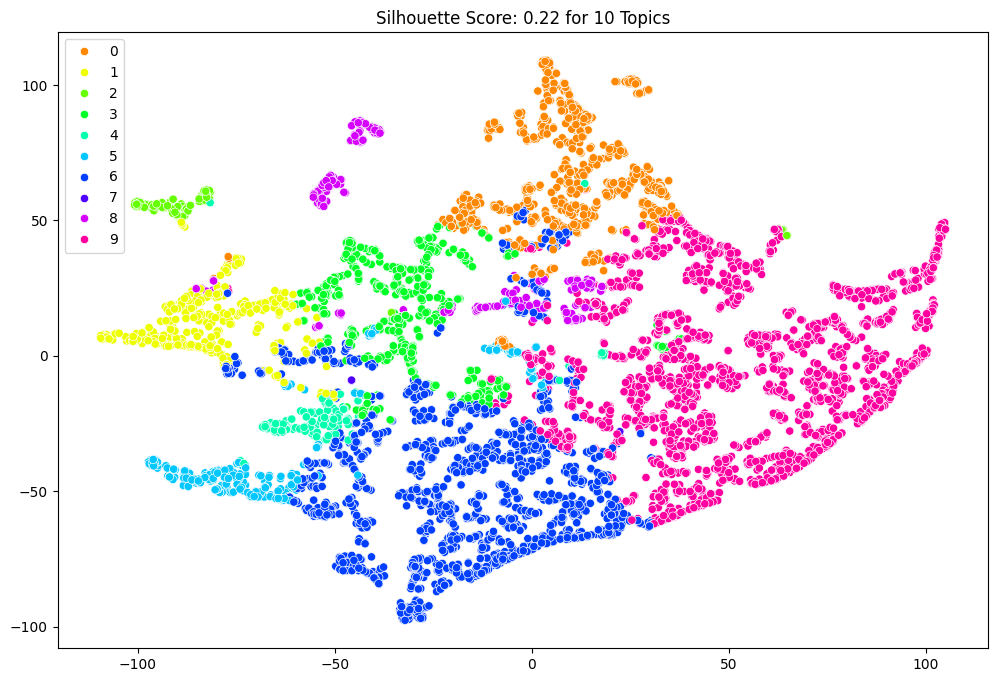

Silhouette scores: {10: 0.22222082}
The optimal number of topics based on Silhouette Score is: 10
----Analyzing finance topics----
----Analyzing legal topics----
----Adding is Enron from and to columns----
----Adding is ECT or EES columns----
----Adding PII and QID columns----
----Adding geographic departmets columns----
----Adding VIP to and from status columns----
----Applying classification and rules----


In [75]:
enron_df_group_16 = apply_classification_on_dataframe(enron_df_group_16)

## Save the DataFrame to Pickle format

In [71]:
enron_df_group_16.to_pickle('labeled_student_group_16.pkl')